# Analyzing the Value Premium
February 2022

*July 2022 Note: Since the start of this notebook in February 2022, the valuation spread between cheap and expensive stocks reverted further to the mean as additional inflationary pressure shifted the government yield curve upwards. Expensive stocks lost ~10% and cheap stocks were fairly flat. The value premium in small stocks has appreciated more than in large stocks.*
<br>
*I expect the large cap valuation spread to revert further to the mean in the coming months.*

## Introduction
In 1992, Eugene Fama and Kenneth French introduced a Three-Factor Model in their famous paper "The Cross-Section of Expected Stock Returns" that extends William Sharpe's CAPM with a Size Factor (SMB) and a Value Factor (HML):
<br><br>
$$ E(r) = \alpha + \beta_{1} *  (MKT-R_f) + \beta_{2} * SMB + \beta_{3} * HML $$
<br>
Given the parsimonous structure, the theoretical existence of state variables that investors want to hedge against and the poor empirical performance of the CAPM, it has become, together with Fama/French's (FF) extended 5-Factor Model from 2015, the standard model to price the cross-section of equity returns.
<br>
However, since the publication of the paper, both factors failed to deliver any premium out-of-sample and the value premium (HML) in particular currently experiences a 20-year drawdown, erasing half of its entire 100-year cumulative outperformance. Sceptics claim that both premia are unrelated to risk and that the model is a result of data snooping. Once the existence of a new factor becomes common knowledge and investors adapt and try to exploit it, it should, via arbitrage, ultimately vanish. 
<br>
While asset pricing theory points to factors aside from the sensitivity to the market portfolio and although the four additional Fama/French factors are theoretically sound as they directly relate to the pricing equation, which in turn might point to a set of state variables in Robert Merton's ICAPM, it is unclear whether they can indeed proxy the underlying risk factors. This notebook puts the theory aside and provides a quantitative analysis of the drivers of the value premium and shows that the value premium still exists and is possibly a historically attractive diversifier in the current market environment.

**Table of Contents:**
1. [Descriptive&nbsp;Analysis](#1.&nbsp;Descriptive&nbsp;Analysis)
2. [Stochastic&nbsp;Analysis](#2.&nbsp;Stochastic&nbsp;Analysis)
3. [Relative&nbsp;Valuations](#3.&nbsp;Relative&nbsp;Valuations)
4. [Explaining&nbsp;Variables](#4.&nbsp;Explaining&nbsp;Variables)
5. [Time-Series&nbsp;Predictability](#5.&nbsp;Time-Series&nbsp;Predictability)
6. [ETF/Stock&nbsp;Selection](#6.&nbsp;ETF/Stock&nbsp;Selection)
7. [Summary](#7.&nbsp;Summary)

**Data sources:**
* [Kenneth French's Portfolio Database](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
* [Robert Shiller's History of CAPE](http://www.econ.yale.edu/~shiller/data.htm)
* [Bond Rates from the Federal Feserve Bank of St. Louis](https://fred.stlouisfed.org/)

**Dependencies:**
* numpy
* pandas
* matplotlib
* statsmodels
* scipy
* [finance_data](https://github.com/Jon-Nie/finance_data)

#### Importing the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import (
    jarque_bera,
    norm,
    gaussian_kde
)
from finance_data import (
    FREDReader,
    FrenchReader,
    MSCIReader,
    YahooReader,
    shiller_cape
)

In [2]:
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (12,6)

In [3]:
shiller_data = shiller_cape()["CAPE"]
shiller_rate = shiller_cape()["10-Year Interest Rate"]

rate_1yr = FREDReader("DGS1").historical_data().resample("MS").first() / 100
rate_1yr.columns = ["1-Year Interest Rate"]
rate_10yr = FREDReader("DGS10").historical_data().resample("MS").first() / 100
rate_10yr.columns = ["10-Year Interest Rate"]

ff3 = FrenchReader("F-F_Research_Data_Factors").read()["Main"] / 100
ff5 = FrenchReader("F-F_Research_Data_5_Factors_2x3").read()["Main"] / 100
mom = FrenchReader("F-F_Momentum_Factor").read()["Main"] / 100

df = pd.concat([ff3, mom, shiller_data], axis=1).dropna()
df["RMW"] = ff5["RMW"]
df["CMA"] = ff5["CMA"]
df = df[["Mkt-RF", "SMB", "HML", "RMW", "CMA", "Mom", "RF", "CAPE"]]

bm_sorted_data = FrenchReader("Portfolios_Formed_on_BE-ME").read()
bm_size_sorted_data = FrenchReader("6_Portfolios_2x3").read()

ep_sorted_data = FrenchReader("Portfolios_Formed_on_E-P").read()
ep_size_sorted_data = FrenchReader("6_Portfolios_ME_EP_2x3").read()

cfp_sorted_data = FrenchReader("Portfolios_Formed_on_CF-P").read()
cfp_size_sorted_data = FrenchReader("6_Portfolios_ME_CFP_2x3").read()

bm_size_5_5_sorted_data = FrenchReader("25_Portfolios_5x5").read()

## 1.&nbsp;Descriptive&nbsp;Analysis

Starting with descriptive statistics, no factor of Fama/French's five-factor model, except for the equity premium itself, has delivered a significant premium since the publication of the respective model in 1992 and 2015, which questions the models out-of-sample performance to price equity risk.

In [4]:
print("Since 1992,...")
for factor in ("Mkt-RF", "SMB", "HML"):   
    ols_fit = OLS(df.loc["1992-01-01":, factor], [1 for _ in range(len(df.loc["1992-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")
print("")
print("Since 2015,...")
for factor in ("RMW", "CMA"):   
    ols_fit = OLS(df.loc["2015-01-01":, factor], [1 for _ in range(len(df.loc["2015-01-01":, :].index))]).fit()
    mean = ols_fit.params["const"]
    tstat = ols_fit.tvalues["const"]
    print(f"...the {factor} factor returned an average of {mean:.2%} per month with a t-statistic of {tstat:.2f}.")

Since 1992,...
...the Mkt-RF factor returned an average of 0.67% per month with a t-statistic of 2.92.
...the SMB factor returned an average of 0.12% per month with a t-statistic of 0.74.
...the HML factor returned an average of 0.22% per month with a t-statistic of 1.28.

Since 2015,...
...the RMW factor returned an average of 0.31% per month with a t-statistic of 1.46.
...the CMA factor returned an average of 0.01% per month with a t-statistic of 0.04.


While all four factors failed to deliver any premium out-of-sample, I will only discuss the value premium as it is the factor that has recently shown the worst performance and because it has a long tradition in equity markets, ranging back to Benjamin Graham in the early 20th century.

Since 2007, the value premium had its largest drawdown in history and shed about half of its entire cumulative outperformance since 1927 ...

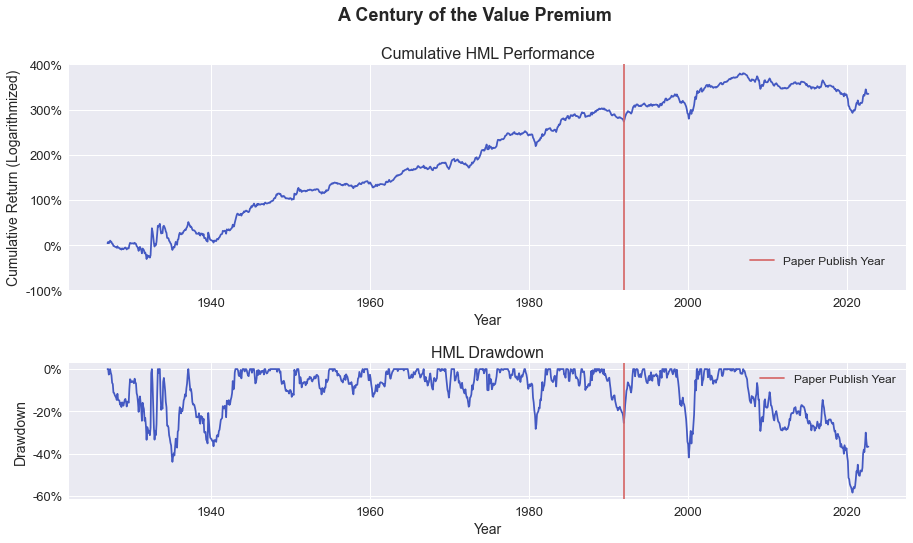

In [5]:
df["HML Cumulative"] = (1+df["HML"]).cumprod()
df["HML Drawdown"] = df["HML Cumulative"] / df["HML Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("A Century of the Value Premium", fontsize=18, fontweight="bold")

axes[0].plot(np.log(df["HML Cumulative"]), color="#4459c2")
axes[0].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[0].set_title("Cumulative HML Performance", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return (Logarithmized)", size=14)
axes[0].tick_params(axis="x", labelsize=13)
yticks = list(range(-1, 5))
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[0].legend(fontsize=12, bbox_to_anchor=(0.8,0.2));

axes[1].plot(df["HML Drawdown"], color="#4459c2")
axes[1].axvline(x=(1992-1970)*365, label="Paper Publish Year", color="#d66b6b")

axes[1].set_title("HML Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)

axes[1].legend(fontsize=12, loc="upper right");

... and the failure of the value premium was both present in large and small caps, although higher in magnitude in the large cap segment.

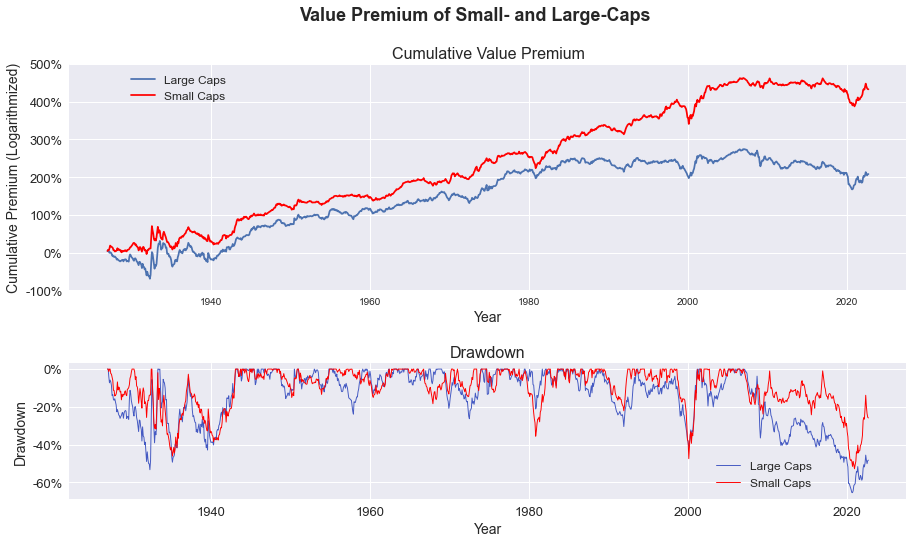

In [6]:
df["Large High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG HiBM"] / 100
df["Large Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["BIG LoBM"] / 100
df["Small High B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL HiBM"] / 100
df["Small Low B/M"] = bm_size_sorted_data["Average Value Weighted Returns Monthly"]["SMALL LoBM"] / 100

df["Large Value Premium"] = df["Large High B/M"] - df["Large Low B/M"] 
df["Large Value Premium Cumulative"] = (1+df["Large Value Premium"]).cumprod()
df["Small Value Premium"] = df["Small High B/M"] - df["Small Low B/M"]
df["Small Value Premium Cumulative"] = (1+df["Small Value Premium"]).cumprod()

df["Large Value Premium Drawdown"] = df["Large Value Premium Cumulative"] / df["Large Value Premium Cumulative"].cummax() - 1
df["Small Value Premium Drawdown"] = df["Small Value Premium Cumulative"] / df["Small Value Premium Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, gridspec_kw={'height_ratios': [5, 3]}, figsize=(15,8))
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premium of Small- and Large-Caps", fontsize=18, fontweight="bold")

axes[0].plot(np.log((1+df["Large Value Premium"]).cumprod()), label="Large Caps")
axes[0].plot(np.log((1+df["Small Value Premium"]).cumprod()), label="Small Caps", color="red")

axes[0].set_title("Cumulative Value Premium", size=16)
axes[0].set_xlabel("Year", fontsize=14)
axes[0].set_ylabel("Cumulative Premium (Logarithmized)", fontsize=14)

yticks = list(range(-1, 6))
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].legend(fontsize=12, bbox_to_anchor=(0.2, 1))

axes[1].plot(df["Large Value Premium Drawdown"], color="#4459c2", linewidth=0.95, label="Large Caps")
axes[1].plot(df["Small Value Premium Drawdown"], color="red", linewidth=0.95, label="Small Caps")

axes[1].set_title("Drawdown", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12, bbox_to_anchor=(0, 0, 0.9, 0.98));

While some people argue that book values are a flawed measure of valuations as highly profitable technology companies with low capital requirements and hence low book-values become more relevant today, the drawdowns look similar if we take net-earnings or cashflows instead of book-values.
<br>
However, the recent drawdowns of value premia based on E/P and CF/P begin a few years later and are not as large in magnitude as the recent drawdown of the book-value-based value premium.
<br>
*(Note that the data for other variables is constrained to a later starting date)*

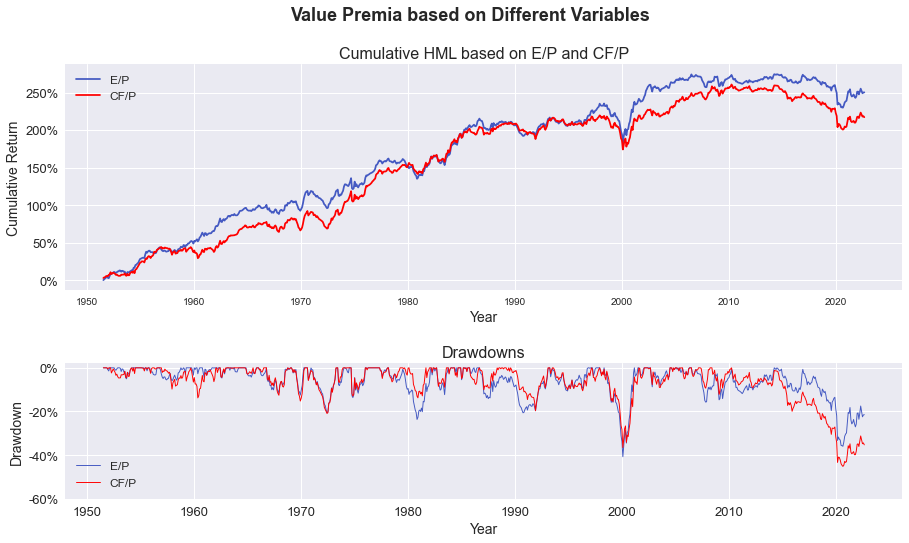

In [7]:
df["Large Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoEP"]) / 100
df["Large Value Premium E/P Cumulative"] = (1+df["Large Value Premium E/P"]).cumprod()
df["Small Value Premium E/P"] = (ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiEP"] - ep_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoEP"]) / 100
df["Small Value Premium E/P Cumulative"] = (1+df["Small Value Premium E/P"]).cumprod()

df["HML E/P"] = (df["Large Value Premium E/P"] + df["Small Value Premium E/P"]) / 2
df["HML E/P Cumulative"] = (1+df["HML E/P"]).cumprod()
df["HML E/P Drawdown"] = df["HML E/P Cumulative"] / df["HML E/P Cumulative"].cummax() - 1

df["Large Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["BIG LoCFP"]) / 100
df["Large Value Premium CF/P Cumulative"] = (1+df["Large Value Premium CF/P"]).cumprod()
df["Small Value Premium CF/P"] = (cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL HiCFP"] - cfp_size_sorted_data["Value Weight Average Returns Monthly"]["SMALL LoCFP"]) / 100
df["Small Value Premium CF/P Cumulative"] = (1+df["Small Value Premium CF/P"]).cumprod()

df["HML CF/P"] = (df["Large Value Premium CF/P"] + df["Small Value Premium CF/P"]) / 2
df["HML CF/P Cumulative"] = (1+df["HML CF/P"]).cumprod()
df["HML CF/P Drawdown"] = df["HML CF/P Cumulative"] / df["HML CF/P Cumulative"].cummax() - 1

figure, axes = plt.subplots(2, figsize=(15,8), gridspec_kw={'height_ratios': [5,3]})
plt.subplots_adjust(hspace=0.4)
figure.suptitle("Value Premia based on Different Variables", fontsize=18, fontweight="bold")

axes[0].plot(np.log(df["HML E/P Cumulative"]), color="#4459c2", label="E/P")
axes[0].plot(np.log(df["HML CF/P Cumulative"]), color="red", label="CF/P")
axes[0].set_title("Cumulative HML based on E/P and CF/P", size=16)
yticks = [0, 0.5, 1, 1.5, 2, 2.5]
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Cumulative Return", size=14)
axes[0].legend(fontsize=12)

axes[1].plot(df["HML E/P Drawdown"], color="#4459c2", linewidth=0.95, label="E/P")
axes[1].plot(df["HML CF/P Drawdown"], color="red", linewidth=0.95, label="CF/P")

axes[1].set_title("Drawdowns", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Drawdown", size=14)
axes[1].tick_params(axis="x", labelsize=13)

yticks = [-0.6,-0.4,-0.2, 0]
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
axes[1].legend(fontsize=12);

The correlations between alternative measures of the value premium also highlight that it does not matter which fundamental variable we use to measure the value premium.

In [8]:
np.round(df[["HML", "HML E/P", "HML CF/P"]].corr(), 2)

,HML,HML E/P,HML CF/P
HML,1.00,0.85,0.83
HML E/P,0.85,1.00,0.89
HML CF/P,0.83,0.89,1.00


To sum it up, the value factor has been terrible recently, no matter of the size of the companies and the variable used. However, there are at least two arguments, considered individually or together, that might invalidate the claim that the recent data points to a vanished value premium:
1. The underperformance is the result of chance.
2. Macroeconomic/fundamentals shifts affected cheap and expensive stocks differently, resulting either in changing valuations or in different unexpected underlying fundamental performances of the companies.

## 2.&nbsp;Stochastic&nbsp;Analysis

Given that all factors carry a sizable amount of risk in the form of volatility, it should be no surprise that a factor, described by a stochastic process with positive mean can underperform for a lengthy period. For example, for an iid normally distributed white-noise process with a yearly mean return of 10% and 20% yearly volatility, there is still a probability of 2% that the process realizes a mean return lower than 0% over a period of 15 years. Likewise, the US market portfolio showed multiple periods of 15-year underperformance against bonds.
<br>
To see whether the underperformance is due to chance, one can compute the pvalues of the realized premium, given the prior return distribution.

Pior to publication in 1992, the Value Premium had delivered an average monthly excess return of

In [9]:
prior_mean = df.loc[:"1992-01-01", "HML"].mean()
print(f"{prior_mean:.2%}")

0.42%


with a monthly volatility of

In [10]:
prior_std = df.loc[:"1992-01-01", "HML"].std()
print(f"{prior_std:.2%}.")

3.69%.


Assuming a gaussian distribution and stationarity between pre- and post-publication (i.e. the same mean and volatility pre- and post-publication), we can compute the probability that the value premium returns an average return below the realized average post-publication return. Given the increasing number of factor ETFs to give retail investors access to alternative factor premia and investors needing some time to fully adapt to new academic research, I do the same for the subsamples of 1997, 2002, 2007 onwards.

In [11]:
print("The respective sample size of each considered subsample is as follows:\n")
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    print(f"The sample size spanning from January {year} to today is {sample_size} months.")

The respective sample size of each considered subsample is as follows:

The sample size spanning from January 1992 to today is 369 months.
The sample size spanning from January 1997 to today is 309 months.
The sample size spanning from January 2002 to today is 249 months.
The sample size spanning from January 2007 to today is 189 months.


Turning to the probabilities, we get the following values.

In [12]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - prior_mean
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.22% per month is 12.23%
For the subsample from January 1997 to today, the probability of an average return less than 0.12% per month is 5.97%
For the subsample from January 2002 to today, the probability of an average return less than 0.01% per month is 1.65%
For the subsample from January 2007 to today, the probability of an average return less than -0.19% per month is 0.57%


So far, one could certainly (and possibly unsurpringly) conclude at some reasonable confidence level that the value premium has a structural break (i.e. a linear mean-shift over time as investors adapt to reserach) between pre- and post-publication of the paper.
However, running the same for a hypothesis of a zero mean-return post-publication gives the following results:

In [13]:
for year in (1992, 1997, 2002, 2007):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    std_err = df.loc[f"{year}-01-01":, "HML"].std() / np.sqrt(sample_size)
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    mean_diff = realized_mean - 0
    z_value = mean_diff / std_err
    p_value = norm.cdf(z_value)
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {p_value:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.22% per month is 90.05%
For the subsample from January 1997 to today, the probability of an average return less than 0.12% per month is 72.44%
For the subsample from January 2002 to today, the probability of an average return less than 0.01% per month is 52.95%
For the subsample from January 2007 to today, the probability of an average return less than -0.19% per month is 21.77%


Therefore, based on the assumptions and the data, it is not possible to argue that the value premium is dead.
<br>
One issue though is that the empirical distribution of the value premium, like many financial time-series, is non-normal, although I assumed normality until now.

Its skewness is

In [14]:
prior_skew = df.loc[:"1992-01-01", "HML"].skew()
np.round(prior_skew, 2)

2.74

and its excess kurtosis is

In [15]:
prior_kurt = df.loc[:"1992-01-01", "HML"].kurt()
print(np.round(prior_kurt, 2), ",", sep="")

22.94,


both well above that of a normal distribution. Accordingly, a jarque-bera test easily rejects the hypothesis of a normal distribution at the 1% level:

In [16]:
jb = jarque_bera(df.loc[:"1992-01-01", "HML"]).pvalue
print(f"{jb:.2%}")

0.00%


The empirical distribution compared to a normal distribution with same mean and variance also highlights the empirical leptokurtic structure:

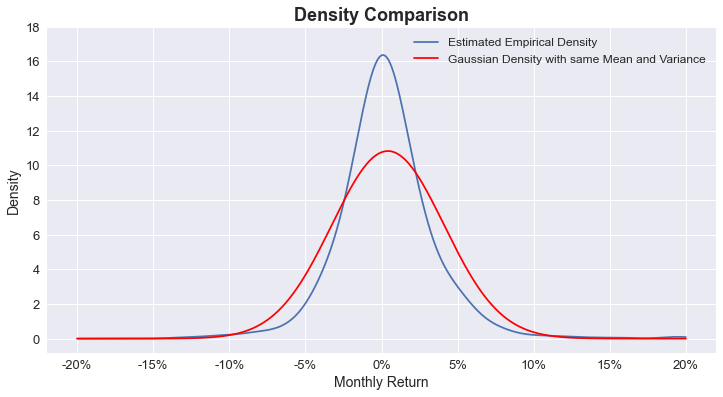

In [17]:
estimated_density = gaussian_kde(df.loc[:"1992-01-01", "HML"])
x = np.linspace(-0.2, 0.2, 1000)

fig, ax = plt.subplots()
ax.plot(x, estimated_density(x), label="Estimated Empirical Density")
ax.plot(x, norm.pdf(x, prior_mean, prior_std), label="Gaussian Density with same Mean and Variance", color="red")

plt.title("Density Comparison", fontsize=18, fontweight="bold")
plt.ylabel("Density", fontsize=14)
plt.xlabel("Monthly Return", fontsize=14)

xticks = [no/100 for no in range(-20, 21, 5)]
ax.set_xticks(xticks, [f"{ret:.0%}" for ret in xticks], fontsize=13)
yticks = list(range(-2, 19, 2))
ax.set_yticks(yticks[1:], yticks[1:], fontsize=13)
ax.set_yticklabels([int(obs) for obs in yticks[1:]], fontsize=13)

ax.legend(fontsize=12);

Therefore, it is important to account for non-normality and compute the same probabilities before by incorporating the empirical distribution instead of assuming normality. For that, I bootstrap intervals by drawing n times (n=sample size) with replacement from the empirical distribution until January 1992. I do it 100.000 times for each subsample and compute the probability of an average return less than the respective realized return by counting the ocurrences and diving it by the total number of bootstrap samples:

In [18]:
series = {}
sample_size = df.loc["1992-01-01":, "HML"].count()
for i in range(100_000):
    series[i] = pd.Series(np.random.choice(df.loc[:f"1992-01-01", "HML"], sample_size))
bootstrapped_df = pd.DataFrame(series)
bootstrapped_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,-0.0413,-0.0142,-0.0287,-0.0029,-0.0081,0.0516,-0.0987,-0.0043,-0.0138,0.0062,...,0.0473,-0.0193,-0.0100,-0.0059,0.0341,0.0325,-0.0284,0.0058,-0.0295,-0.0857
1,0.0117,0.0562,0.0106,0.0020,-0.0053,0.0450,0.0054,0.0411,-0.0009,-0.0039,...,-0.0034,0.0192,0.0602,0.0133,-0.0248,-0.0146,-0.0015,0.0558,-0.0193,0.0163
2,0.0240,0.0608,-0.0024,0.0044,0.0200,0.0281,0.0385,0.0085,0.0413,0.0269,...,-0.0096,0.0060,0.0133,0.0221,0.0020,0.0170,-0.0296,0.0124,-0.0015,-0.0594
3,-0.0281,0.0473,-0.0086,0.0177,0.0161,-0.0215,-0.0149,-0.0050,-0.0138,-0.0190,...,-0.0160,-0.0074,-0.0243,0.0044,0.0200,-0.0222,0.0903,0.0084,0.0216,0.0064
4,0.0351,-0.0194,-0.0270,-0.0039,0.0044,-0.0059,0.0179,-0.0033,-0.0641,-0.0071,...,-0.0142,-0.0113,0.0344,0.0227,0.0407,-0.0531,-0.0286,-0.0156,-0.0421,-0.0048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,-0.0039,0.0104,0.0070,-0.0066,0.0066,0.0046,-0.0052,0.0163,-0.0095,-0.0831,...,0.0032,0.1010,0.0056,0.0012,-0.0016,0.0434,0.0451,-0.0131,0.0073,-0.0067
365,0.0381,-0.0033,-0.0132,-0.0048,0.0068,0.0069,-0.0003,0.0023,-0.0063,0.0081,...,0.0124,0.0060,-0.0033,-0.0885,-0.0169,-0.0589,-0.0010,-0.0469,0.1965,-0.0109
366,0.0069,0.0059,0.0356,0.0198,-0.0001,0.0396,-0.0772,-0.0228,0.0163,0.0517,...,0.0082,-0.0459,0.0015,-0.0099,0.0043,0.0030,0.0037,0.0471,0.0075,-0.0198
367,0.0406,0.0100,-0.0180,-0.0146,-0.0111,0.1356,0.0019,0.0214,0.0135,0.0144,...,0.0112,0.0066,-0.0194,0.0177,-0.0504,-0.0033,-0.0066,-0.0064,-0.0034,0.0333


In [19]:
for year in (1992, 1997, 2002, 2007):
    realized_mean = df.loc[f"{year}-01-01":, "HML"].mean()
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    prob = (bootstrapped_df.iloc[:sample_size, :].mean().sort_values().reset_index(drop=True) < realized_mean).sum() / 100_000
    print(f"For the subsample from January {year} to today, the probability of an average return less than {realized_mean:.2%} per month is {prob:.2%}")

For the subsample from January 1992 to today, the probability of an average return less than 0.22% per month is 14.55%
For the subsample from January 1997 to today, the probability of an average return less than 0.12% per month is 6.83%
For the subsample from January 2002 to today, the probability of an average return less than 0.01% per month is 3.52%
For the subsample from January 2007 to today, the probability of an average return less than -0.19% per month is 0.81%


And the same results in graphical representation look as follows:

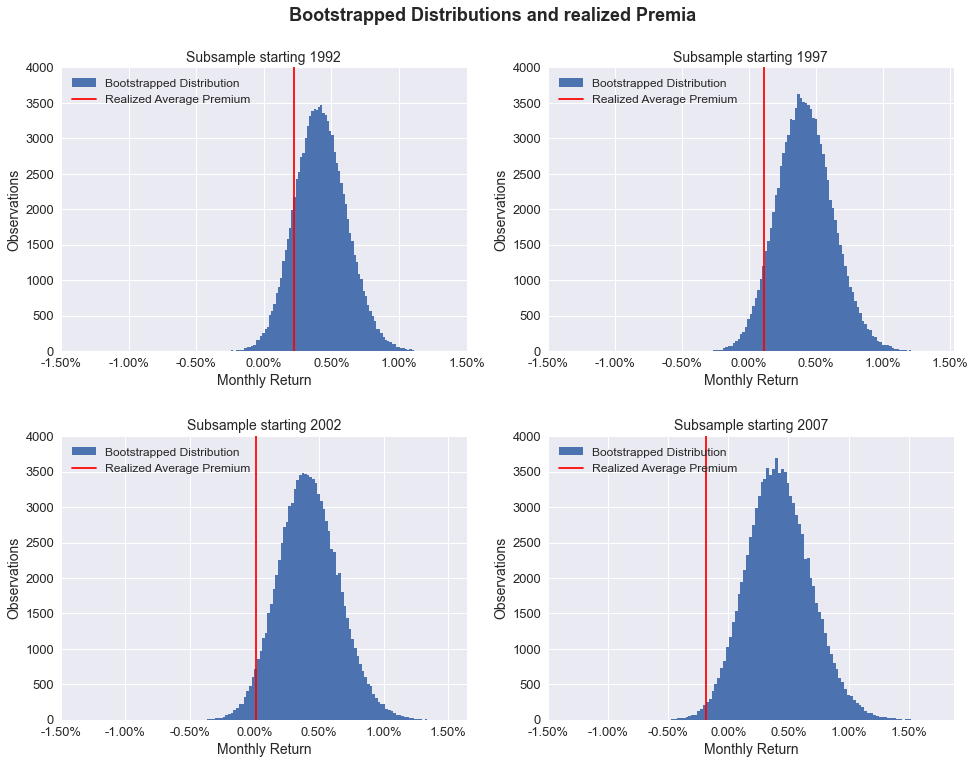

In [20]:
figure, axes = plt.subplots(2, 2, figsize=(16,12))
plt.subplots_adjust(hspace=0.3)
figure.suptitle("Bootstrapped Distributions and realized Premia", fontsize=18, fontweight="bold", y=0.95)

for year, (x, y) in zip((1992, 1997, 2002, 2007), ((0,0), (0,1), (1,0), (1,1))):
    sample_size = df.loc[f"{year}-01-01":, "HML"].count()
    axes[x,y].hist(bootstrapped_df.iloc[:sample_size, :].mean(), bins=100, label="Bootstrapped Distribution")
    axes[x,y].axvline(df.loc[f"{year}-01-01":, "HML"].mean(), color="red", label="Realized Average Premium")
    
    axes[x,y].set_title(f"Subsample starting {year}", fontsize=14)
    axes[x,y].set_xlabel("Monthly Return", fontsize=14)
    axes[x,y].set_ylabel("Observations", fontsize=14)
    
    xticks = np.linspace(-0.015, 0.015, 7)
    axes[x,y].set_xticks(xticks)
    axes[x,y].set_xticklabels([f"{ret:.2%}" for ret in xticks], fontsize=13)
    yticks = axes[x,y].get_yticks().tolist()
    axes[x,y].set_yticks(yticks)
    axes[x,y].set_yticklabels([int(obs) for obs in yticks], fontsize=13)
    
    axes[x,y].legend(fontsize=12)

Although the probabilities are a bit higher than when I assumed normality, the main message remains the same and the post-publication value premium is either a statistical outlier or the process exhibits a structural mean-shift. However, as I have shown, the hypothesis that the post-publication mean return is zero cannot be rejected (which can also be seen if we shift the boostrapped distributions to the left so that it has a zero mean). Therefore, looking at the mere data, there is no indication of a dead value premium.

## 3.&nbsp;Relative&nbsp;Valuations

While a basket of stocks with the same characteristics (e.g. same magnitude of market beta) should deliver its expected premium over the long term, it can deviate quite a lot from that over the shorter term for various reasons. Valuations of stocks change continuously as the business cycle affects the discount rate, new news getting priced in and many other factors.
<br>
The shorter the period, the higher is the effect of changing valuations compared to the embedded premium on returns.
For example, the daily equity premium is a few basis points and the volatility of around 100 basis points dominates, but over decades, positive and negative shocks cancel each other out and the premium overweighs. Following the financial crisis 2008/09, the realized US equity premium was well above its historical average since it benefited quite a lot from changes in valuations.

The US equity premium from 1927 to today was

In [21]:
equity_premium = df["Mkt-RF"].mean()*12
print(f"{equity_premium:.2%},")

7.93%,


while the average from 2009 to today was

In [22]:
equity_premium_recent = df.loc["2009-01-01": , "Mkt-RF"].mean()*12
print(f"{equity_premium_recent:.2%},")

12.92%,


or

In [23]:
sigma = ((df["Mkt-RF"].std() * np.sqrt(12)) / np.sqrt(df.loc["2009-01-01": , "Mkt-RF"].count()/12))
np.round((equity_premium_recent - equity_premium) / sigma, 2)

1.0

standard deviations above its expected value using the full sample mean and assuming normality.

Accordingly, a large portion of US stock returns since 2009 have been the result of changing valuations, measured in terms of the [CAPE](https://www.nber.org/system/files/working_papers/w8221/w8221.pdf) (which is a function of risk aversion, profitability and expected earnings growth), and not by fundamental drivers such as abnormally high realized earnings growth or dividends.

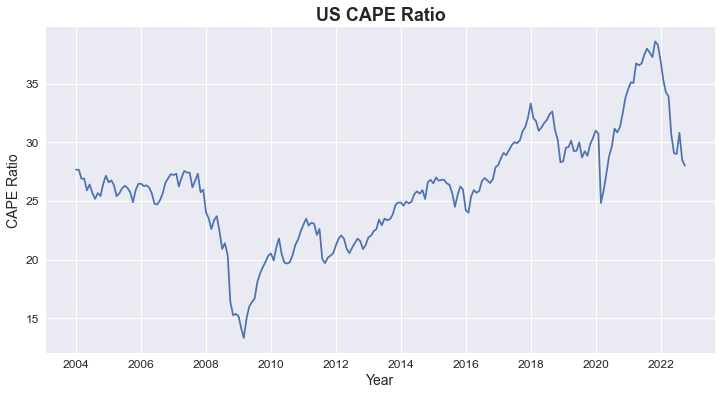

In [24]:
plt.plot(shiller_data.loc["2004-01-01":])

plt.title("US CAPE Ratio", fontsize=18, fontweight="bold")
plt.ylabel("CAPE Ratio", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In a similar fashion, the realized value premium is the result of three factors:
1. The difference of the ex-ante risk premia between cheap and expensive stocks
2. The change in relative valuations due to changing expectations
3. Unexpected fundamental changes that do not affect the relative valuations, e.g. a one-time shock that affect earnings but do not affect expectations going forward and hence also not affect relative valuations
<br>

Again, over a long enough sample, (2) and (3) should have little effect, but over the short term, they can be the main driver of the value premium.

Starting with the question whether cheap stocks are historically cheap or expensive stocks are historically expensive, we can compute the z-score of the respective valuation metric (book-to-market, earnings/price, cashflow/price). Because I use variable/market value instead of the often used reciprocal (e.g. price/earnings multiple), positive z-scores indicate historically cheap valuations since we get more fundamental value per amount of market value.
<br>
I use 30th-percentile and 70th-percentile data for expensive and cheap stocks, respectively, provided by Kenneth French on an annual basis computed at the end of June and fill the data in-between with the realized value premium.

In [25]:
spreads = pd.DataFrame(index = df.index)
spreads["High B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Hi 30"]
spreads["Low B/M Ratio"] = bm_sorted_data["Value Weight Average of BE / ME"]["Lo 30"]

spreads["Large High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["BIG HiBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]
spreads["Large Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["BIG LoBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]
spreads["Small High B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["SMALL HiBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]
spreads["Small Low B/M Ratio"] = bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"]["SMALL LoBM"][bm_size_sorted_data["Value Weight Average of BE_FYt-1/ME_June"].index.month == 7]

for i, index in enumerate(df.index):
    if index in bm_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High B/M Ratio"]):
            spreads.loc[index, "High B/M Ratio"] = spreads.loc[df.index[i-1], "High B/M Ratio"] / (1+bm_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low B/M Ratio"]):
            spreads.loc[index, "Low B/M Ratio"] = spreads.loc[df.index[i-1], "Low B/M Ratio"] / (1+bm_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
    
    if index in bm_size_sorted_data["Average Value Weighted Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High B/M Ratio"]):
            spreads.loc[index, "Large High B/M Ratio"] = spreads.loc[df.index[i-1], "Large High B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "BIG HiBM"]/100)
        if np.isnan(spreads.loc[index, "Large Low B/M Ratio"]):
            spreads.loc[index, "Large Low B/M Ratio"] = spreads.loc[df.index[i-1], "Large Low B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "BIG LoBM"]/100)
        if np.isnan(spreads.loc[index, "Small High B/M Ratio"]):
            spreads.loc[index, "Small High B/M Ratio"] = spreads.loc[df.index[i-1], "Small High B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "SMALL HiBM"]/100)
        if np.isnan(spreads.loc[index, "Small Low B/M Ratio"]):
            spreads.loc[index, "Small Low B/M Ratio"] = spreads.loc[df.index[i-1], "Small Low B/M Ratio"] / (1+bm_size_sorted_data["Average Value Weighted Returns Monthly"].loc[index, "SMALL LoBM"]/100)

spreads["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
spreads["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]

spreads["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
spreads["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
spreads["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
spreads["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]

spreads["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
spreads["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]

spreads["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
spreads["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
spreads["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
spreads["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]

for i, index in enumerate(df.index):
    if index in ep_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High E/P Ratio"]):
            spreads.loc[index, "High E/P Ratio"] = spreads.loc[df.index[i-1], "High E/P Ratio"] / (1+ep_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Low E/P Ratio"]):
            spreads.loc[index, "Low E/P Ratio"] = spreads.loc[df.index[i-1], "Low E/P Ratio"] / (1+ep_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
    
    if index in ep_size_sorted_data["Value Weight Average Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High E/P Ratio"]):
            spreads.loc[index, "Large High E/P Ratio"] = spreads.loc[df.index[i-1], "Large High E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG HiEP"]/100)
        if np.isnan(spreads.loc[index, "Large Low E/P Ratio"]):
            spreads.loc[index, "Large Low E/P Ratio"] = spreads.loc[df.index[i-1], "Large Low E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG LoEP"]/100)
        if np.isnan(spreads.loc[index, "Small High E/P Ratio"]):
            spreads.loc[index, "Small High E/P Ratio"] = spreads.loc[df.index[i-1], "Small High E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL HiEP"]/100)
        if np.isnan(spreads.loc[index, "Small Low E/P Ratio"]):
            spreads.loc[index, "Small Low E/P Ratio"] = spreads.loc[df.index[i-1], "Small Low E/P Ratio"] / (1+ep_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL LoEP"]/100)

    if index in cfp_sorted_data["Value Weight Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "High CF/P Ratio"]):
            spreads.loc[index, "High CF/P Ratio"] = spreads.loc[df.index[i-1], "High CF/P Ratio"] / (1+cfp_sorted_data["Value Weight Returns Monthly"].loc[index, "Hi 30"]/100)
        if np.isnan(spreads.loc[index, "Large Low CF/P Ratio"]):
            spreads.loc[index, "Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Low CF/P Ratio"] / (1+cfp_sorted_data["Value Weight Returns Monthly"].loc[index, "Lo 30"]/100)
            
    if index in cfp_size_sorted_data["Value Weight Average Returns Monthly"].index:
        if np.isnan(spreads.loc[index, "Large High CF/P Ratio"]):
            spreads.loc[index, "Large High CF/P Ratio"] = spreads.loc[df.index[i-1], "Large High CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG HiCFP"]/100)
        if np.isnan(spreads.loc[index, "Large Low CF/P Ratio"]):
            spreads.loc[index, "Large Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Large Low CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "BIG LoCFP"]/100)
        if np.isnan(spreads.loc[index, "Small High CF/P Ratio"]):
            spreads.loc[index, "Small High CF/P Ratio"] = spreads.loc[df.index[i-1], "Small High CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL HiCFP"]/100)
        if np.isnan(spreads.loc[index, "Small Low CF/P Ratio"]):
            spreads.loc[index, "Small Low CF/P Ratio"] = spreads.loc[df.index[i-1], "Small Low CF/P Ratio"] / (1+cfp_size_sorted_data["Value Weight Average Returns Monthly"].loc[index, "SMALL LoCFP"]/100)

In [26]:
z_scores = {
    "High": pd.DataFrame(index = ["B/M", "E/P", "CF/P"], columns=["All", "Large", "Small"]),
    "Low": pd.DataFrame(index = ["B/M", "E/P", "CF/P"], columns=["All", "Large", "Small"])
}
z_scores["High"].index.name = "Cheap Stocks"
z_scores["Low"].index.name = "Expensive Stocks"
for breakpoint in z_scores.keys():
    for var in z_scores[breakpoint].index:
        for cap in z_scores[breakpoint].columns:
            if cap == "All":
                name = f"{breakpoint} {var} Ratio"
            else:
                name = f"{cap} {breakpoint} {var} Ratio"
            z_scores[breakpoint].loc[var, cap] = (spreads[name][-1] - spreads[name].mean()) / spreads[name].std()
display(z_scores["High"].applymap(lambda x: round(x, 2)))
display(z_scores["Low"].applymap(lambda x: round(x, 2)))

,All,Large,Small
Cheap Stocks,,,
B/M,-0.59,-0.48,-0.36
E/P,0.65,0.67,0.82
CF/P,0.10,0.10,0.41


,All,Large,Small
Expensive Stocks,,,
B/M,-1.30,-1.06,-0.56
E/P,-0.70,-0.70,-1.03
CF/P,-0.93,-0.92,-1.17


Both cheap and expensive stocks are pricey compared to their historical averages, which, given the current low rate environment, is not suprising. However, expensive stocks seem to be disproportionately expensive based on book-value/market-value and earnings/price ratios.

To gain further insight, we can take a look at the relative valuations of stocks with high book-to-market ratios and those with low book-to-market ratios, both in small- and large-caps.

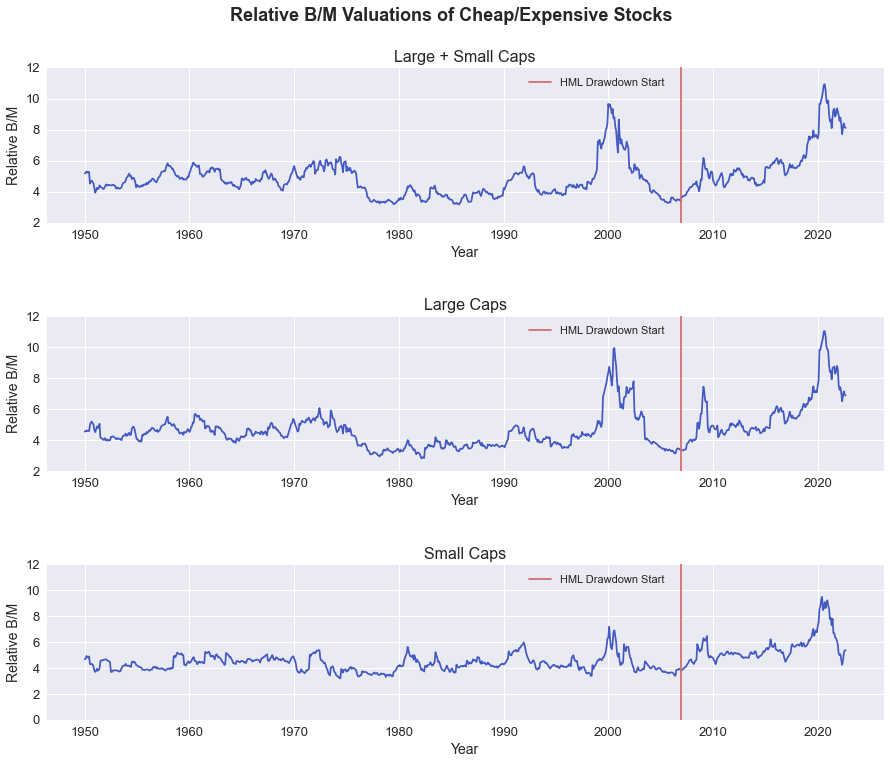

In [27]:
spreads["Valuation Spread All"] = spreads["High B/M Ratio"] / spreads["Low B/M Ratio"]
spreads["Valuation Spread Large"] = spreads["Large High B/M Ratio"] / spreads["Large Low B/M Ratio"]
spreads["Valuation Spread Small"] = spreads["Small High B/M Ratio"] / spreads["Small Low B/M Ratio"]

figure, axes = plt.subplots(3, figsize=(15,12))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative B/M Valuations of Cheap/Expensive Stocks", fontsize=18, fontweight="bold", y=0.95)

axes[0].plot(spreads["Valuation Spread All"]["1950-01-01":], color="#4459c2")
axes[0].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[0].set_title("Large + Small Caps", size=16)
axes[0].set_xlabel("Year", size=14)
axes[0].set_ylabel("Relative B/M", size=14)
axes[0].tick_params(axis="x", labelsize=13)
axes[0].tick_params(axis="y", labelsize=13)
axes[0].set_yticks(list(range(2,13,2)))

axes[0].legend(fontsize=11, loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.25, 0.5));

axes[1].plot(spreads["Valuation Spread Large"]["1950-01-01":], color="#4459c2")
axes[1].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[1].set_title("Large Caps", size=16)
axes[1].set_xlabel("Year", size=14)
axes[1].set_ylabel("Relative B/M", size=14)
axes[1].tick_params(axis="x", labelsize=13)
axes[1].tick_params(axis="y", labelsize=13)
axes[1].set_yticks(list(range(2,13,2)))

axes[1].legend(fontsize=11, loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.25, 0.5));

axes[2].plot(spreads["Valuation Spread Small"]["1950-01-01":], color="#4459c2")
axes[2].axvline(x=(2007-1970)*365, label="HML Drawdown Start", color="#d66b6b")

axes[2].set_title("Small Caps", size=16)
axes[2].set_xlabel("Year", size=14)
axes[2].set_ylabel("Relative B/M", size=14)
axes[2].tick_params(axis="x", labelsize=13)
axes[2].tick_params(axis="y", labelsize=13)
axes[2].set_yticks(list(range(0,13,2)))

axes[2].legend(fontsize=11, loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.25, 0.5));

It becomes clear that relative valuations increased dramatically since the start of the HML drawdown in January 2007 with relative valuations widening between 200% and 250% and that the current level is similar to that of the 2000 dotcom bubble and the great depression in the 1930s.

The picture looks similar when using net-earnings or cashflows as the fundamental variable instead of book-values, although the widening is not as significant as for book-values. *(Again, the data starts later)*

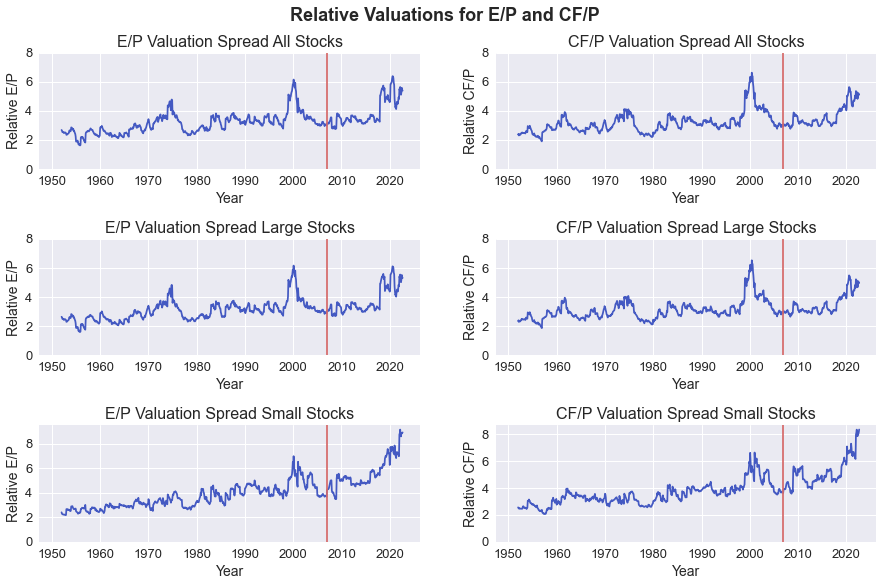

In [28]:
spreads["E/P Valuation Spread All"] = spreads["High E/P Ratio"] / spreads["Low E/P Ratio"]
spreads["E/P Valuation Spread Large"] = spreads["Large High E/P Ratio"] / spreads["Large Low E/P Ratio"]
spreads["E/P Valuation Spread Small"] = spreads["Small High E/P Ratio"] / spreads["Small Low E/P Ratio"]
spreads["CF/P Valuation Spread All"] = spreads["High CF/P Ratio"] / spreads["Low CF/P Ratio"]
spreads["CF/P Valuation Spread Large"] = spreads["Large High CF/P Ratio"] / spreads["Large Low CF/P Ratio"]
spreads["CF/P Valuation Spread Small"] = spreads["Small High CF/P Ratio"] / spreads["Small Low CF/P Ratio"]

df["High E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Hi 30"]
df["Low E/P Ratio"] = ep_sorted_data["Value Weight Average of E / ME"]["Lo 30"]
df["E/P Valuation Spread All"] = (df["High E/P Ratio"] / df["Low E/P Ratio"]).ffill()

df["Large High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG HiEP"]
df["Large Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["BIG LoEP"]
df["E/P Valuation Spread Large"] = (df["Large High E/P Ratio"] / df["Large Low E/P Ratio"]).ffill()

df["Small High E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL HiEP"]
df["Small Low E/P Ratio"] = ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"]["SMALL LoEP"]
df["E/P Valuation Spread Small"] = (df["Small High E/P Ratio"] / df["Small Low E/P Ratio"]).ffill()

df["High CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 30"]
df["Low CF/P Ratio"] = cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 30"]
df["CF/P Valuation Spread All"] = (df["High CF/P Ratio"] / df["Low CF/P Ratio"]).ffill()

df["Large High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG HiCFP"]
df["Large Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["BIG LoCFP"]
df["CF/P Valuation Spread Large"] = (df["Large High CF/P Ratio"] / df["Large Low CF/P Ratio"]).ffill()

df["Small High CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL HiCFP"]
df["Small Low CF/P Ratio"] = cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"]["SMALL LoCFP"]
df["CF/P Valuation Spread Small"] = (df["Small High CF/P Ratio"] / df["Small Low CF/P Ratio"]).ffill()


figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,9))
plt.subplots_adjust(hspace=0.6)
figure.suptitle("Relative Valuations for E/P and CF/P", fontsize=18, fontweight="bold", y=0.95)

for row, dataset in enumerate((
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small"
)):

    axes[row, 0].plot(spreads[dataset], color="#4459c2")
    axes[row, 0].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 0].set_title(f"{dataset} Stocks", size=16)
    axes[row, 0].set_xlabel("Year", size=14)
    yticks = list(range(0,9,2))
    axes[row, 0].set_yticks(yticks)
    axes[row, 0].set_yticklabels([int(tick) for tick in yticks], size=13)
    axes[row, 0].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 0].tick_params(axis="both", labelsize=13)

for row, dataset in enumerate((
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
)):
    axes[row, 1].plot(spreads[dataset], color="#4459c2")
    axes[row, 1].axvline(x=(2007-1970)*365, color="#d66b6b")
    axes[row, 1].set_title(f"{dataset} Stocks", size=16)
    axes[row, 1].set_xlabel("Year", size=14)
    yticks = list(range(0,9,2))
    axes[row, 1].set_yticks(yticks)
    axes[row, 1].set_yticklabels([int(tick) for tick in yticks], size=13)
    axes[row, 1].set_ylabel(f"Relative {dataset.split()[0]}", size=14)
    axes[row, 1].tick_params(axis="both", labelsize=13)

This indicates that the value premium during the last 15 years was to a large extent driven by changing relative valuations between cheap and expensive stocks. Hence, the "fundamental" value premium that accounts for unexpected changes in the explaining factors of relative valuations therefore might not have been as bad as it first seems when looking solely at the data.

## 4.&nbsp;Explaining&nbsp;Variables

Because the change in relative valuations of cheap and expensive stocks has a big impact on the realized premium, we should analyze the value premium adjusted for changes in the state vector that contains variables that describe the current market environment and affect relative valuations.
<br>
The naive way to do so is to adjust the premium by subtracting the change in valuation. For example, when the value premium returns 100% and expensive stocks double their relative valuation compared to cheap stocks, the adjusted premium would be zero. However, this would ignore changes that also justify changes in relative valuations (such as expensive stocks becoming more profitable) and the adjusted premium would be biased.
<br>
A better way is therefore to find variables that affect relative valuations, adjust the valuation spread to those variables and subtract the adjusted valuation spread from the value premium to compute a "fundamental" value premium.

Starting with the simple pricing equation, any asset price should equal the sum of all excess cashflows it will generate during its lifetime, discounted to the present.
<br>
<br>
$$ Market\;Value = \sum \limits_{t=1} ^{\infty} \frac{Free\;Cashflow_t}{(1+Discount\;Rate_t)^{t}} $$
<br>
Assuming a flat term structure of discount rates, a constant growth rate of free-cashflows and that the discount rate is higher than the growth rate, the resulting geometric series can be simplified to
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Discount\;Rate-Growth\;Rate} $$
<br>
The discount rate of any asset consists of its risk premium and the rate one would get on a riskless asset.
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Growth\;Rate} $$
<br>
The growth rate of free cashflows is governed by the reinvestment rate scaled by profitability. If all earnings are reinvested with a return on equity (and assuming constant leverage) of 10%, then the growth rate of free-cashflows and earnings has to be 10%. Likewise, if only 50% of cashflows are reinvested, the growth rate would be 5%.
<br>
<br>
$$ Market\;Value = \frac{Free\;Cashflow}{Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity} $$
<br>
Rearranging gives
<br>
<br>
$$ \frac{Free\;Cashflow}{Market\;Value} = Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity $$
<br>
Since $Free\;Cashflow = (1 + Reinvestment\;Rate) * Earnings$, we get
<br>
<br>
$$ \frac{Earnings}{Market\;Value} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{1-Reinvestment\;Rate} $$
<br>
Operating Cashflows equal Earnings after Working Capital changes, which in most cases should not be too large and hence can be ignored so that we can also write
<br>
<br>
$$ \frac{Operating\;Cashflow}{Market\;Value} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{1-Reinvestment\;Rate} $$
<br>
Book-Values and Earnings are related via the Return on Equity. Thus, we can also consider Book-to-Market ratios:
<br>
<br>
$$ \frac{Book\;Value}{Market\;Value} = (Riskfree\;Rate+Risk\;Premium-Reinvestment\;Rate*Return\;On\;Equity) * \frac{1}{(1-Reinvestment\;Rate)*Return\;On\;Equity} $$

The conclusion is that the amount of earnings, cashflows or book-value one gets for every amount of market value increases with the risk-free rate, increases with the risk premium and decreases with the return on equity.
<br>
Terefore the valuation spread between cheap and expensive stocks (e.g. book-to-market ratios of cheap stocks divided by book-to-market ratios of expensive stocks)
1. **increases** with the risk premium differential between cheap and expensive stocks
2. **decreases** with the profitability difference between cheap and expensive stocks
*The relationship between valuation ratios and reinvestment rate depends on the values of the discount rate and profitability. Because Kenneth French does not provide data on reinvestment rates anyways, I ignore it.*

In addition, expensive stocks tend to grow faster than cheap stocks and hence have a higher portion of their net present value in the distant future than cheap stocks. That is why expensive stocks are more interest-rate sensitive (i.e. have a higher duration) than cheap stocks. For example, at a discount rate of 5%, the net present value of 100 dollar in 10 (30) years would be 61.39 (23.14). An increase of 1% in the discount rate would change net present values to 55.84 and 17.41, resulting in relative changes of -9.05% and -24.76%, respectively.
<br>
Because risk-free rates are generally not constant across all maturities, cashflows across different maturities are discounted with different rates. The implication is that even though the yield curve shifts upwards, cheap stocks could drop more than expensive stocks if short-term rates rise much faster (or drop much less) than long-term rates.
<br>
We can hence disentangle the partial effects of the yield curve on valuation spreads by stating that

3. the **higher** the level of the yield curve (i.e. the T-bill or short-term T-note rate), the **lower** are valuation spreads of cheap and expensive stocks
4. the **steeper** the slope of the yield curve (i.e. the higher the difference between long-term rates and short-term rates), the **lower** are valuation spreads of expensive and cheap stocks

Kenneth French provides only operating profitability data for stocks sorted on book-to-market ratios. I therefore report OLS estimates of the yield curve level and slope for earnings/price and cashflow/price sorted stocks but will ignore them in further analysis.
<br>
To analyze the impact of each variable, I use the 1-year interest rate as the level of the yield curve and the difference between the 10-year interest rate and the 1-year interest rate as the slope of the yield curve.
<br>
As operating profitability, I use the operating profit divided by book equity, provided by Kennneth French. Because profitability time-series of stocks with the lowest 30% book-to-market ratios exhibit heavy outliers, I use data of the second quintile (book-to-market ratios between 20th and 40th percentile) instead.

In [29]:
spread_labels = (
    "Valuation Spread All",
    "Valuation Spread Large",
    "Valuation Spread Small",
    "E/P Valuation Spread All",
    "E/P Valuation Spread Large",
    "E/P Valuation Spread Small",
    "CF/P Valuation Spread All",
    "CF/P Valuation Spread Large",
    "CF/P Valuation Spread Small"
)
ols_df = pd.DataFrame(index=bm_size_sorted_data["Value Weight Average of OP"].index)
for ts in spread_labels:
    ols_df[ts] = spreads[ts]
ols_df = ols_df.dropna()
ols_df["1-Year Interest Rate"] = rate_1yr
ols_df["10-Year Interest Rate"] = rate_10yr
ols_df["Level"] = ols_df["1-Year Interest Rate"]
ols_df["Slope"] = ols_df["10-Year Interest Rate"] - ols_df["1-Year Interest Rate"]
ols_df["Large Cheap Profitability"] = bm_size_sorted_data["Value Weight Average of OP"]["BIG HiBM"]
ols_df["Large Expensive Profitability"] = bm_size_5_5_sorted_data["Value Weight Average of OP"]["ME5 BM2"]
ols_df["Small Cheap Profitability"] = bm_size_sorted_data["Value Weight Average of OP"]["SMALL HiBM"]
ols_df["Small Expensive Profitability"] = bm_size_5_5_sorted_data["Value Weight Average of OP"]["ME1 BM2"]

Starting with the impact of the yield curve level and slope on each valuation spread, I regress the log-spread on the level and slope because changes in the discount rate should have an exponential effect on the price of an asset and hence also on its valuation relative to any fundamental variable.

In [30]:
adjusted_spreads = {}
ols_results = pd.DataFrame(columns = ["Level", "Slope", "R^2"], index = spread_labels)
ols_results.index.name = "Significance Level: 10%: *, 5%: **, 1%: ***"
for series in spread_labels:
    res = OLS(
        np.log(ols_df[series]), 
        add_constant(ols_df[["Level", "Slope"]])
    ).fit()
    params = res.params
    pvalues = res.pvalues
    for var in ("Level", "Slope"):
        if pvalues[var] < 0.01:
            significance = "***"
        elif pvalues[var] < 0.05:
            significance = "**"
        elif pvalues[var] < 0.1:
            significance = "*"
        else:
            significance = ""
        ols_results.loc[series, var] = "{:.2f}{}".format(params[var], significance)
    ols_results.loc[series, "R^2"] = f"{res.rsquared_adj:.2f}"
    adjusted_spreads[series] = res.resid

for sample in ("All", "Large", "Small"):
    adjusted_spreads[f"Average Valuation Spread {sample}"] = (adjusted_spreads[f"Valuation Spread {sample}"]*2 + adjusted_spreads[f"E/P Valuation Spread {sample}"] + adjusted_spreads[f"CF/P Valuation Spread {sample}"])/4
ols_results

,Level,Slope,R^2
"Significance Level: 10%: *, 5%: **, 1%: ***",,,
Valuation Spread All,-5.02***,-8.60***,0.32
Valuation Spread Large,-5.30***,-7.19***,0.35
Valuation Spread Small,-3.03***,-3.49***,0.24
E/P Valuation Spread All,-2.30***,-2.53***,0.11
E/P Valuation Spread Large,-2.36***,-3.20***,0.11
E/P Valuation Spread Small,-4.07***,0.21,0.29
CF/P Valuation Spread All,-2.07***,-1.63**,0.10
CF/P Valuation Spread Large,-1.98***,-1.86**,0.09
CF/P Valuation Spread Small,-4.29***,-0.76,0.37


Two oberservations are worth noting.
1. As expected, both the level and the slope of the yield curve have a signifant effect on valuation spreads for almost all valuation spreads.
2. Less variance is explained for earnings/price and cashflow/price computed valuation spreads than for book-to-market valuation spreads. This should be expected since earnings and cashflows are noisy, book values are more persistent and hence expected earnings and cashflows can deviate much more from their respective current value than book-values.

For now, I skip the analysis of profitability on each valuation spread as it gives ambiguous results. The yield curve however already has a big impact on valuation spreads.

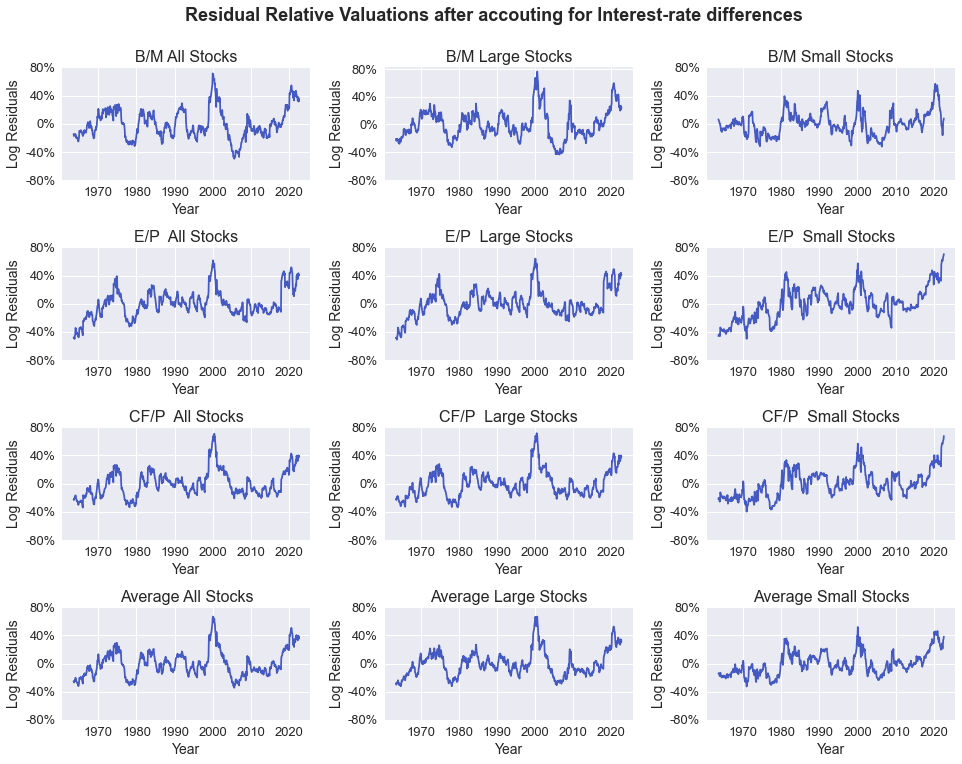

In [31]:
figure, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,12))
plt.subplots_adjust(hspace=0.6, wspace=0.3)
figure.suptitle("Residual Relative Valuations after accouting for Interest-rate differences", fontsize=18, fontweight="bold", y=0.95)

for row, variable in enumerate(("", "E/P ", "CF/P ")):
    for col, sample in enumerate(("All", "Large", "Small")):
    
        axes[row, col].plot(adjusted_spreads[f"{variable}Valuation Spread {sample}"], color="#4459c2")
        if variable == "":
            var_name = "B/M"
        else:
            var_name = variable            
        axes[row, col].set_title(f"{var_name} {sample} Stocks", size=16)
        axes[row, col].set_xlabel("Year", size=14)
        yticks = [-0.8, -0.4, 0, 0.4, 0.8]
        axes[row, col].set_yticks(yticks)
        axes[row, col].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
        axes[row, col].set_ylabel("Log Residuals", size=14)
        axes[row, col].tick_params(axis="both", labelsize=13)

for col, sample in enumerate(("All", "Large", "Small")):
        axes[3, col].plot(adjusted_spreads[f"Average Valuation Spread {sample}"], color="#4459c2")      
        axes[3, col].set_title(f"Average {sample} Stocks", size=16)
        axes[3, col].set_xlabel("Year", size=14)
        yticks = [-0.8, -0.4, 0, 0.4, 0.8]
        axes[3, col].set_yticks(yticks)
        axes[3, col].set_yticklabels([f"{tick:.0%}" for tick in yticks], size=13)
        axes[3, col].set_ylabel("Log Residuals", size=14)
        axes[3, col].tick_params(axis="both", labelsize=13)

## 5.&nbsp;Time-Series&nbsp;Predictability

## 6.&nbsp;ETF/Stock&nbsp;Selection

To set up the trade, it is crucial to know what type of stocks or ETFs one should look for, i.e. how high or low the multiples should be. I now use the more common reciprocal multiple and report quantile multiples of price/book, price/earnings and price/cashflow multiples *(hence the lower, the better)*, both for the full sample and distinguished between large and small caps.

In [32]:
multiples_single = pd.DataFrame(columns=["P/E", "P/CF", "P/B"])
for i in range(10, 0, -1):
    if i == 1:
        multiples_single.loc["Highest 10%", "P/E"] = 1/ep_sorted_data["Value Weight Average of E / ME"]["Lo 10"].iloc[-1]
        multiples_single.loc["Highest 10%", "P/CF"] = 1/cfp_sorted_data["Value Weight Average of CF / ME"]["Lo 10"].iloc[-1]
        multiples_single.loc["Highest 10%", "P/B"] = 1/bm_sorted_data["Value Weight Average of BE / ME"]["Lo 10"].iloc[-1]
    elif i == 10:
        multiples_single.loc["Lowest 10%", "P/E"] = 1/ep_sorted_data["Value Weight Average of E / ME"]["Hi 10"].iloc[-1]
        multiples_single.loc["Lowest 10%", "P/CF"] = 1/cfp_sorted_data["Value Weight Average of CF / ME"]["Hi 10"].iloc[-1]
        multiples_single.loc["Lowest 10%", "P/B"] = 1/bm_sorted_data["Value Weight Average of BE / ME"]["Hi 10"].iloc[-1]
    else:
        multiples_single.loc[f"{(i)/10:.0%}", "P/E"] = 1/ep_sorted_data["Value Weight Average of E / ME"][f"Dec {i}"].iloc[-1]
        multiples_single.loc[f"{(i)/10:.0%}", "P/CF"] = 1/cfp_sorted_data["Value Weight Average of CF / ME"][f"Dec {i}"].iloc[-1]
        multiples_single.loc[f"{(i)/10:.0%}", "P/B"] = 1/bm_sorted_data["Value Weight Average of BE / ME"][f"Dec {i}"].iloc[-1]
multiples_single = multiples_single.applymap(lambda x: np.round(x, 2))


multiples_double = pd.DataFrame(
    columns=["P/E", "P/CF", "P/B"],
    index=pd.MultiIndex.from_product([["Large", "Small"], ["Lowest 30%", "70%", "Highest 30%"]])
)
i = 0
for size in range(1, -1, -1):
    for value in range(2, -1, -1):
        multiples_double.loc[multiples_double.index[i], "P/E"] = (1/ep_size_sorted_data["Value Weight Average of E/P when portfolio is formed"].iloc[-1, size*3+value])
        multiples_double.loc[multiples_double.index[i], "P/CF"] = (1/cfp_size_sorted_data["Value Weight Average of CF/P when portfolio is formed"].iloc[-1, size*3+value])
        multiples_double.loc[multiples_double.index[i], "P/B"] = (1/bm_size_sorted_data["Value Weight Average of BE/ME"].iloc[-1, size*3+value])
        i += 1
multiples_double = multiples_double.applymap(lambda x: np.round(x, 2))

In [33]:
display(multiples_single)
display(multiples_double)

,P/E,P/CF,P/B
Lowest 10%,4.85,4.31,0.77
90%,8.13,6.71,1.24
80%,10.75,9.17,1.57
70%,14.08,11.36,1.89
60%,16.95,13.70,2.42
50%,22.22,16.39,3.11
40%,27.03,20.00,3.97
30%,32.26,26.32,5.75
20%,45.45,34.48,8.13
Highest 10%,125.00,76.92,21.28


P/E   P/CF    P/B
Large Lowest 30%    8.38   6.76   1.28
      70%          20.66  15.80   2.62
      Highest 30%  45.45  35.34  11.33
Small Lowest 30%    6.92   5.50   1.04
      70%          18.32  14.14   2.70
      Highest 30%  60.61  43.86   7.91

It becomes clear that one should choose a basket of stocks or ETFs with
<br>
1. price/earnings < 11
2. price/cashflows < 10
3. price/book < 1.5

and avoid or short stocks / ETFs with
1. price/earnings > 35
2. price/cashflows > 30
3. price/book > 6

Turning to ETFs for european investors, there are some UCITS-compliant ETFs with significantly positive and negative value-factor loadings, covering the United States, Europe, Emerging Markets and global stock universes.
<br>
For comparison purposes, I report year-to-date returns in US-Dollar. If someone is long an ETF with US stocks and the EUR/USD exchange rate falls, the ETF would outperform a european counterpart with exactly the same metrics. Therefore, to account for an implicit currency bet, I translate all returns that are not in US-Dollar to USD returns by multiplying the ETF return with the change in the currency rate of that currency to the US-Dollar.

In [34]:
global_factors = FrenchReader("Developed_5_Factors").read()["Main"] / 100
eu_factors = FrenchReader("Europe_5_Factors").read()["Main"] / 100
em_factors = FrenchReader("Emerging_5_Factors").read()["Main"] / 100

eur_usd = YahooReader("EURUSD=X").historical_data(frequency="1mo")["data"]["simple_returns"]
eur_usd.index = [pd.to_datetime(item.date()) for item in eur_usd.index]

gbp_usd = YahooReader("GBPUSD=X").historical_data(frequency="1mo")["data"]["simple_returns"]
gbp_usd.index = [pd.to_datetime(item.date()) for item in gbp_usd.index]

In [35]:
# Long ETFs
long_etfs = {
    "IE00BSPLC413": "ZPRV.DE",
    "IE00BJRCLL96": "JPGL.DE",
    "IE00BP3QZB59": "IS3S.DE",
    "IE00BJRCLK89": "JPUS",
    "IE00BF2B0K52": "FLXE.DE",
    "IE00BG0SKF03": "5MVL.DE",
    "IE00BSPLC298": "ZPRX.DE"
}

long_etf_exposures = pd.DataFrame(columns=["Name", "ISIN", "MKT", "SMB", "HML", "RMW", "R2", "YTD Dollar Return"])
long_etf_exposures.index.name = "Ticker"
etf_list = []
for isin, ticker in long_etfs.items():
    reader = YahooReader(ticker)
    name = reader.name
    long_etf_exposures.loc[ticker, ["Name", "ISIN"]] = [name, isin]
    
    historical_data = reader.historical_data(frequency="1mo")
    series = historical_data["data"]["simple_returns"]
    series.index = [pd.to_datetime(item.date()) for item in series.index]
    
    currency = historical_data["information"]["currency"]    
    if currency == "EUR":
        series = ((1+series) * (1+eur_usd) - 1).dropna()
    
    ytd_return = (1+series["2022-01-01":]).cumprod()[-1] - 1
    ytd_return = f"{ytd_return:.2%}"
    
    series.name = ticker
    etf_list.append(series)
    
    if ticker in ("ZPRV.DE", "JPUS"):
        temp_df = pd.concat([series, ff5], axis=1).dropna()
    elif ticker in ("JPGL.DE", "IS3S.DE"):
        temp_df = pd.concat([series, global_factors], axis=1).dropna()
    elif ticker == "ZPRX.DE":
        temp_df = pd.concat([series, eu_factors], axis=1).dropna()
    elif ticker in ("FLXE.DE", "5MVL.DE"):
        temp_df = pd.concat([series, em_factors], axis=1).dropna()
    
    ols = OLS(temp_df[ticker], add_constant(temp_df[["Mkt-RF", "SMB", "HML", "RMW"]])).fit()
    long_etf_exposures.loc[ticker, ["MKT", "SMB", "HML", "RMW", "R2", "YTD Dollar Return"]] = list(ols.params[1:].apply(lambda x: round(x, 2))) + [round(ols.rsquared, 2), ytd_return]

# Short ETFs
short_etfs = {
    "DE000ETFL037": "EL4C.DE",
    "IE00BDVPNG13": "WTAI.L",
    "IE00BLPK3577": "WCBR.MI",
    "IE00BJGWQN72": "KLWD.L"
}

short_etf_exposures = pd.DataFrame(columns=["Name", "ISIN", "MKT", "SMB", "HML", "RMW", "R2", "YTD Dollar Return"])
short_etf_exposures.index.name = "Ticker"
etf_list = []
for isin, ticker in short_etfs.items():
    reader = YahooReader(ticker)
    name = reader.name
    short_etf_exposures.loc[ticker, ["Name", "ISIN"]] = [name, isin]
    
    historical_data = reader.historical_data(frequency="1mo")
    series = historical_data["data"]["simple_returns"]
    series.index = [pd.to_datetime(item.date()) for item in series.index]
    
    currency = historical_data["information"]["currency"]
    if currency == "EUR":
        series = ((1+series) * (1+eur_usd) - 1).dropna()
    elif currency == "GBp":
        series = ((1+series) * (1+gbp_usd) - 1).dropna()
    
    ytd_return = (1+series["2022-01-01":]).cumprod()[-1] - 1
    ytd_return = f"{ytd_return:.2%}"
    
    series.name = ticker
    etf_list.append(series)
    
    if ticker == "EL4C.DE":
        temp_df = pd.concat([series, eu_factors], axis=1).dropna()
    elif ticker in ("WTAI.L", "WCBR.MI", "KLWD.L"):
        temp_df = pd.concat([series, ff5], axis=1).dropna()
    
    ols = OLS(temp_df[ticker], add_constant(temp_df[["Mkt-RF", "SMB", "HML", "RMW"]])).fit()
    short_etf_exposures.loc[ticker, ["MKT", "SMB", "HML", "RMW", "R2", "YTD Dollar Return"]] = list(ols.params[1:].apply(lambda x: round(x, 2))) + [round(ols.rsquared, 2), ytd_return]

In [36]:
print("\nPotential Long ETF Candidates\n", "_"*40, sep="")
display(long_etf_exposures.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x).style.applymap(lambda x: "font-weight: bold; color: #00a800", subset="HML"))

print("\nPotential Short ETF Candidates\n", "_"*40, sep="")
display(short_etf_exposures.applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x).style.applymap(lambda x: "font-weight: bold; color: #e00000", subset="HML"))


Potential Long ETF Candidates
________________________________________


,Name,ISIN,MKT,SMB,HML,RMW,R2,YTD Dollar Return
Ticker,,,,,,,,
ZPRV.DE,SPDR MSCI USA Small Cap Value Weighted UCITS ETF,IE00BSPLC413,1.16,0.86,0.27,0.02,0.92,-12.96%
JPGL.DE,JPM Global Equity Multi-Factor UCITS ETF,IE00BJRCLL96,0.93,0.06,0.18,0.50,0.97,-16.29%
IS3S.DE,iShares Edge MSCI World Value Factor UCITS ETF USD (Acc),IE00BP3QZB59,0.95,0.52,0.21,-0.75,0.58,-17.42%
JPUS,JPMorgan Diversified Return U.S. Equity ETF,IE00BJRCLK89,0.92,-0.01,0.18,0.18,0.93,-10.26%
FLXE.DE,Franklin LibertyQ Emerging Markets UCITS ETF,IE00BF2B0K52,0.81,-0.24,0.39,0.60,0.94,-25.79%
5MVL.DE,iShares Edge MSCI EM Value Factor UCITS ETF,IE00BG0SKF03,0.83,-0.45,0.47,0.49,0.91,-24.52%
ZPRX.DE,SPDR MSCI Europe Small Cap Value Weighted UCITS ETF,IE00BSPLC298,1.15,0.71,0.45,0.19,0.97,-28.39%



Potential Short ETF Candidates
________________________________________


,Name,ISIN,MKT,SMB,HML,RMW,R2,YTD Dollar Return
Ticker,,,,,,,,
EL4C.DE,Deka STOXX Europe Strong Growth 20 UCITS ETF,DE000ETFL037,1.04,0.79,-0.80,-0.18,0.75,-50.58%
WTAI.L,WisdomTree Artificial Intelligence UCITS ETF,IE00BDVPNG13,0.99,1.05,-0.49,-0.12,0.85,-43.45%
WCBR.MI,WisdomTree Cybersecurity UCITS ETF,IE00BLPK3577,0.94,1.45,-0.59,-1.05,1.00,-45.92%
KLWD.L,WisdomTree Cloud Computing UCITS ETF,IE00BJGWQN72,1.04,0.29,-0.72,-0.95,0.83,-55.89%


Putting it together, all long candidates have meaningful value-factor loadings, although the short candidates have twice as high loadings in magnitude. Thus there are three possibilities to harvest the value premium going-forward:
1. Go long a single or multiple long candidates. Given the negative correlation between the market premium and value premium, the sharpe ratio should be superior than that of a market portfolio. However, the performance boost is limited.
<br><br>
2. Set up a market-neutral trade that mimicks the value premium by going long a basket of long candidates and short a basket of short candidates. With that, value-factor loadings should be around 1 and the trade also gives high exposure to the profitability factor (RMW). In line with the value premium, this trade would have yielded 15-30% excess return year-to-date, depending on the etf selection.
<br><br>
3. Pursue a mix of 1. and 2. by leveraging up long candidates to >100% of the portfolio and simultaneously short a basket of short candidates such that the beta of the portfolio remains around 1. The result is a portfolio like that in alternative 1, but with much higher value- and profitability-factor loadings. Hence, both the sharpe ratio and expected return should be higher than in alternative 1.

## 7.&nbsp;Summary

In this notebook, I have analyzed the value premium in the United States. I have shown that the claim that it has vanished due to arbitrage is overblown and that a look at the past performance can be misleading. In fact, a simple stochastic analysis revealed that the hypothesis of a zero-mean value premium can be easily rejected.
<br><br>
Because prices and expected returns are inversely related, all else being equal, and since valuation differentials between cheap and expensive stocks are at historically high levels, one can conclude that either the expected value premium or the difference of earnings growth between expensive and cheap stocks is historically high. The latter has yet to turn into reality and given the 2000 dotcom bubble should be viewed with caution.
<br>
Even after accounting for today's low interest rates and the diffent durations of cheap and expensive stocks results in historically high valuation spreads and given the fast tightening of the central bank this year, interest-rate adjusted spreads remain that high.
<br><br>
Finally, an investor aiming at high exposure to the value factor should look for stocks with reasonably low multiples (i.e. P/E < 11, P/CF < 10, P/B < 1.5) and avoid or in a market-neutral trade short stocks with high multiples (P/E > 35, P/CF > 30, P/B > 6).